In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In this tutorial, we will demonstrate the usage patterns for the `transit_periodogram` package that is to be submitted to `atropy.stats`.
To run this tutorial, you need to instal `transit_periodogram` following the instructions in [the README](https://github.com/dfm/astropy-transit-periodogram).
You will also need `numpy`, `scipy`, `matplotlib`, and `astropy`.

The transit periodogram is a modern implementation of the "box least-squares" (BLS) method developed [by Kovács et al. (2002)](https://arxiv.org/abs/astro-ph/0206099).
This is the standard algorithm used to detect transiting exoplanets in time series datasets.
We won't go into the details here, but the basic idea is that the transit is modeled as a top hat and, under the assumption of known independent Gaussian uncertainties, this leads to several simplifications that make evaluating the model likelihood (relatively) computationally efficient.
The transit periodogram computes the log likelihood of the "box" fit (maximized over transit depth, duration, and phase) for a list of periods.
Peaks in the periodogram generally indicate transiting planets or other unmodeled noise.
Methods for determining the false alarm rates with these methods is an active area of research so we won't go into that here, but users should always be cautious with their interpretation of the results from a method like this.

To demonstrate the code, we start by downloading the K2 light curve for `K2-3` a system with 3 known transiting planets:

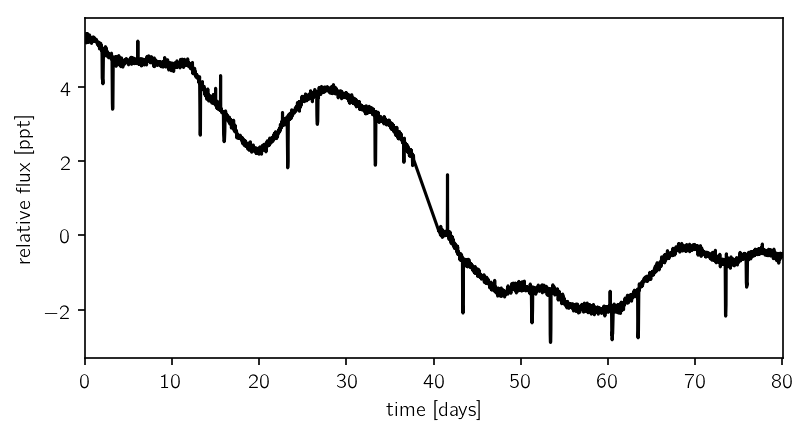

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits

url = "https://archive.stsci.edu/hlsps/everest/v2/c01/201300000/67065/hlsp_everest_k2_llc_201367065-c01_kepler_v2.0_lc.fits"
with fits.open(url) as hdus:
    data = hdus[1].data
    t = data["TIME"]
    y = data["FLUX"]
    q = data["QUALITY"]
    
# This is from the EVEREST source. These are the flagged data points
# that should be removed. Ref: https://github.com/rodluger/everest
m = np.isfinite(t) & np.isfinite(y)
for b in [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]:
    m &= (q & (2 ** (b - 1))) == 0

t = np.ascontiguousarray(t[m] - t[m].min(), dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
y = (y / np.median(y) - 1)*1e3

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3))
ax.plot(t, y, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("relative flux [ppt]");

Then we'll fit for the long-term trends using a running windowed median filter.

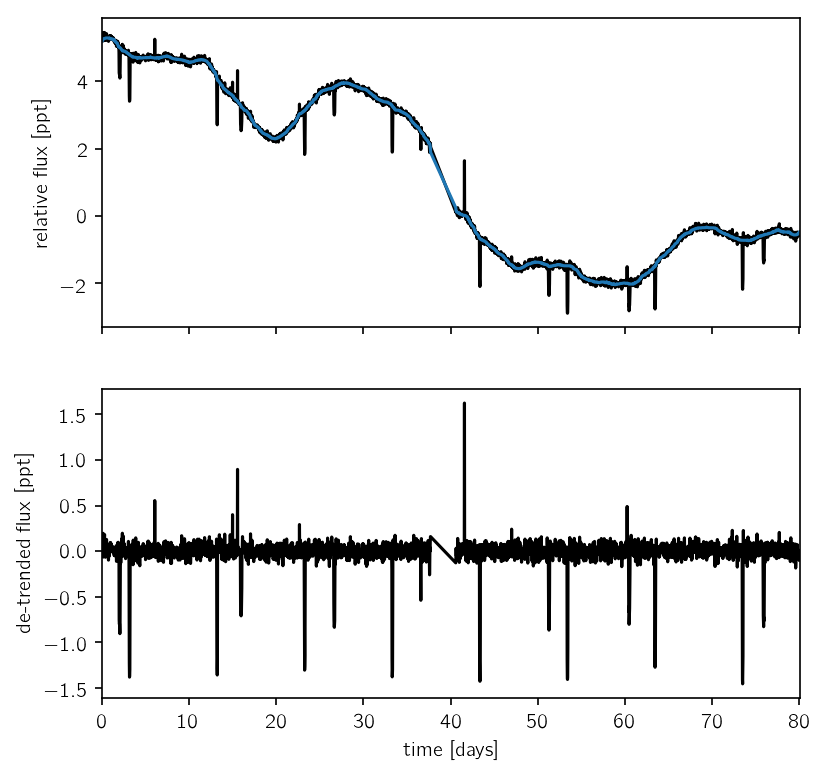

In [3]:
from scipy.signal import medfilt
trend = medfilt(y, 45)
mu = np.median(y)
y_filt =(y - trend)

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 6))
ax = axes[0]
ax.plot(t, y, "k")
ax.plot(t, trend)
ax.set_ylabel("relative flux [ppt]")

ax = axes[1]
ax.plot(t, y_filt, "k")
ax.set_xlim(t.min(), t.max())
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

Now, to find a transiting planet in this light curve, we use the `TransitPeriodogram` class.
The interface was designed to follow the conventions of `astropy.stats.LombScargle` so this might seem familiar to those of you who are familiar with that.

First, the user must select a set of durations to test (in the same units as the time variable above) and then a search can be run using the following commands (see the docstrings for all the options):

In [6]:
from bls import BLS
durations = np.linspace(0.05, 0.2, 10)
model = BLS(t, y_filt)
results = model.autopower(durations)
print(results)

          depth: array([0.01149651, 0.01171579, 0.01168104, ..., 0.73637175, 0.61095512,
       0.61095512])
      depth_err: array([0.04057764, 0.04059689, 0.04059689, ..., 0.37832923, 0.316664  ,
       0.316664  ])
      depth_snr: array([0.28332141, 0.28858843, 0.28773241, ..., 1.94637817, 1.92934819,
       1.92934819])
       duration: array([0.085, 0.085, 0.085, ..., 0.065, 0.085, 0.1  ])
 log_likelihood: array([0.05095148, 0.05284502, 0.05253198, ..., 1.89785174, 1.8663308 ,
       1.8663308 ])
      objective: 'likelihood'
         period: array([ 0.4       ,  0.40000125,  0.4000025 , ..., 40.01389036,
       40.02638037, 40.03887817])
          power: array([0.05095148, 0.05284502, 0.05253198, ..., 1.89785174, 1.8663308 ,
       1.8663308 ])
   transit_time: array([ 0.3425,  0.3425,  0.3425, ..., 33.3125, 13.4025, 13.395 ])


The output from this method has several useful columns, but the most useful ones are probably `period` and `power`.
Using these, we can find plot the periodogram:

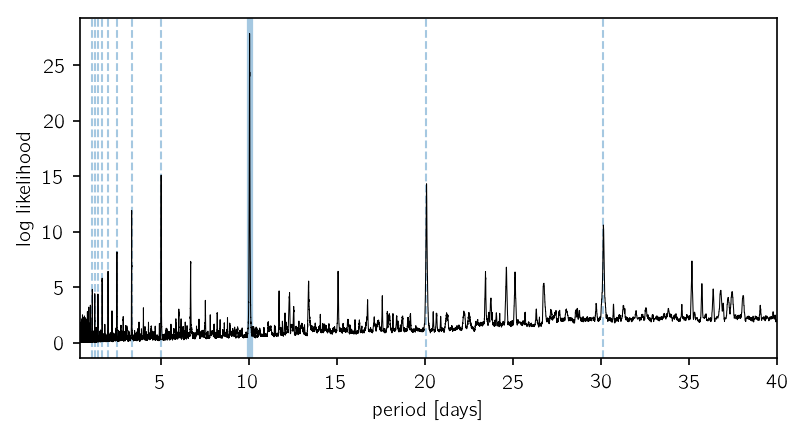

In [7]:
# Find the period of the peak
period = results.period[np.argmax(results.power)]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

# Highlight the harmonics of the peak period
ax.axvline(period, alpha=0.4, lw=3)
for n in range(2, 10):
    ax.axvline(n*period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results.period, results.power, "k", lw=0.5)

ax.set_xlim(results.period.min(), results.period.max())
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood");

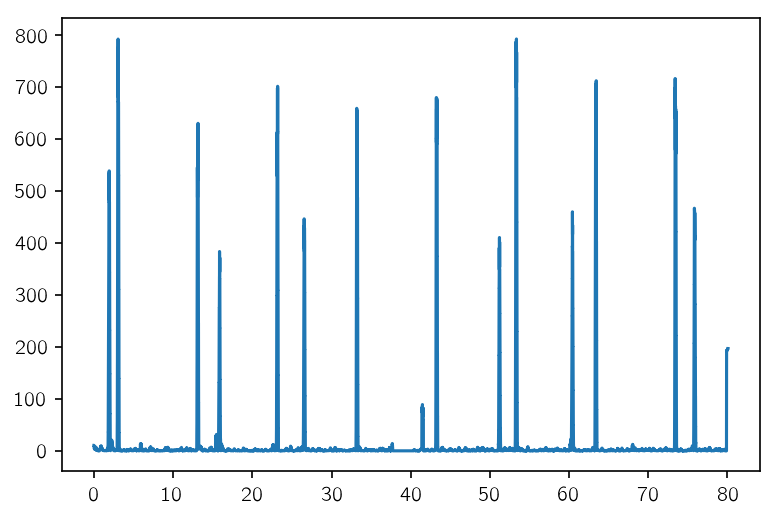

In [73]:
yerr = np.median(np.abs(np.diff(y_filt))) + np.zeros_like(y_filt)
ivar = 1.0 / yerr**2

oversample = 100
db = durations[-1] / oversample
bins = np.arange(t.min(), t.max() + db, db)
num, _ = np.histogram(t, bins, weights=y_filt*ivar)
denom, _ = np.histogram(t, bins, weights=ivar)

num = np.append(num, num[:oversample])
denom = np.append(denom, denom[:oversample])

num = np.cumsum(num)
denom = np.cumsum(denom)
num_all = num[-oversam]
denom_all = denom[-1]

num = num[oversample:] - num[:-oversample]
denom = denom[oversample:] - denom[:-oversample]
num_out = num_all - num
denom_out = denom_all - denom

m = denom > 0
h_in = np.zeros_like(num)
h_in[m] = num[m] / denom[m]
h_out = num_out / denom_out
depth = h_out - h_in
ivar = denom * denom_out / denom_all

log_like_ref = 0.5*num_all**2/denom_all
delta_log_like = 0.5*h_out*num_out + 0.5*h_in*num - log_like_ref

bin_starts = bins[:-1]

plt.plot(bin_starts, delta_log_like)

In [61]:
period = results.period[np.argmax(results.power)]
period

10.05368468798676

In [63]:
from tqdm import tqdm

N = len(delta_log_like)
max_n = int(np.round(np.max(results.period) / db))
min_n = int(np.round(np.min(results.period) / db))
ns = np.arange(min_n, max_n+1)
periods = db * ns
power = np.empty_like(periods)

for j, bins_per_period in tqdm(enumerate(ns), total=len(ns)):
#     bins_per_period = j
    total = int(np.ceil(N / bins_per_period) * bins_per_period)
    tmp = np.zeros(total)
    tmp[:N] = delta_log_like
    ll = np.sum(tmp.reshape((-1, bins_per_period)), axis=0)
    tmp[:N] = depth * ivar
    num = np.sum(tmp.reshape((-1, bins_per_period)), axis=0)
    tmp[:N] = ivar
    denom = np.sum(tmp.reshape((-1, bins_per_period)), axis=0)
    
    m = denom > 0
    best_depth = np.zeros_like(num)
    best_depth[m] = num[m] / denom[m]
    tmp2 = np.zeros(total)
    tmp2[:N] = depth
    resid2 = (tmp2.reshape((-1, bins_per_period)) - best_depth)**2
    resid2 *= tmp.reshape((-1, bins_per_period))
    
    ll -= 0.5 * np.sum(resid2, axis=0)

    power[j] = np.max(ll)
    del tmp
    del tmp2
    del ll

100%|██████████| 19820/19820 [00:08<00:00, 2245.27it/s]


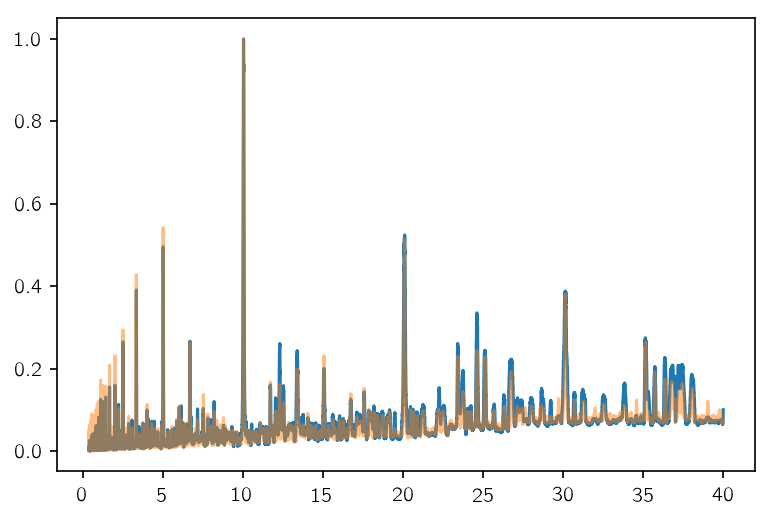

In [69]:
plt.plot(periods, power / np.max(power))
plt.plot(results.period, results.power / np.max(results.power), alpha=0.5)

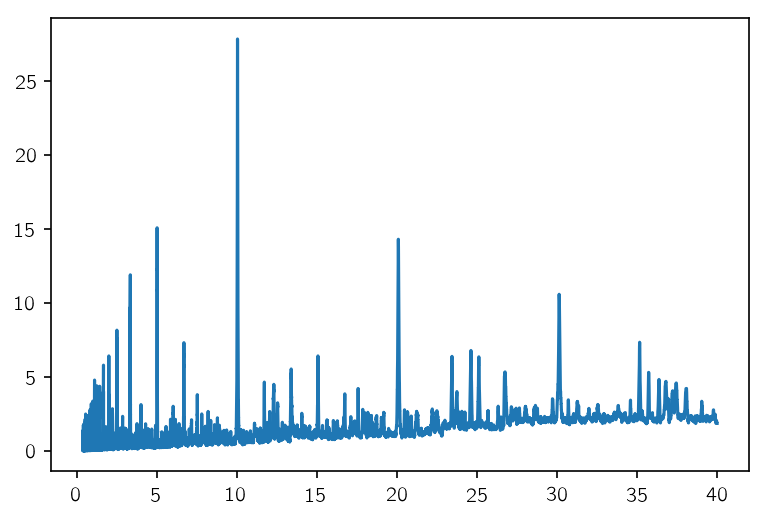

In [65]:
plt.plot(results.period, results.power)

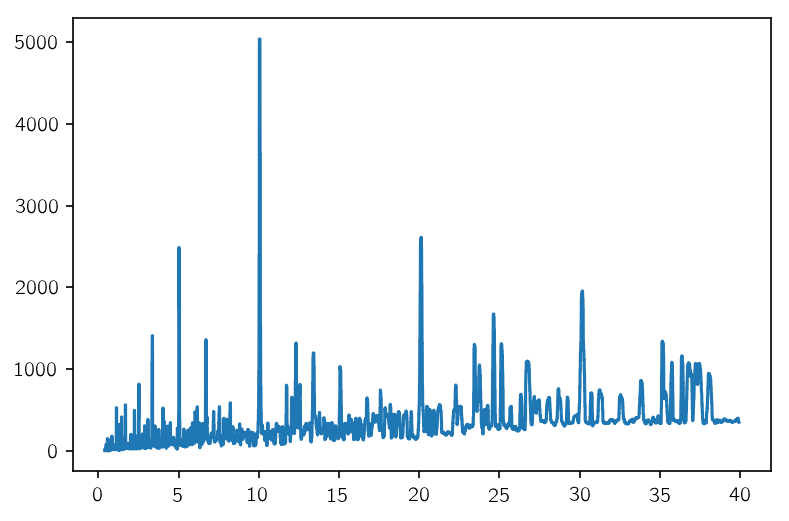

In [46]:
plt.plot(results.period[:k], power[:k])

In [68]:
results.transit_time[index]

3.155

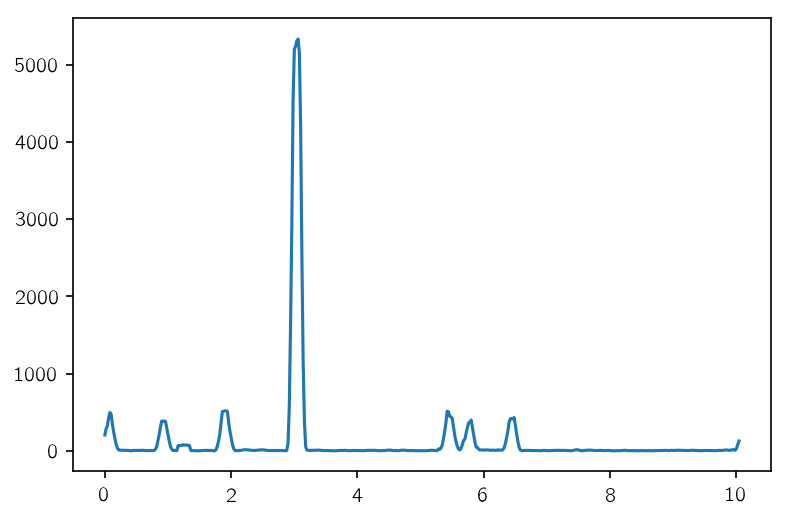

In [69]:
plt.plot(t0, ll)

The structure that you can see in this periodogram is pretty typical for systems with transiting planets.
The peak period is highlighted with a thick blue line and the integer harmonics of this period are indicated with dashed blue lines.
The code can compute some descriptive stats at the maximum peak that are useful for vetting our transit candidate:

In [12]:
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

model.compute_stats(period, duration, t0)

{'depth': (1.21022444799407, 0.16307676409384031),
 'depth_even': (1.1873669172062102, 0.23002134783754802),
 'depth_half': (0.65249740395712796, 0.12069157154651625),
 'depth_odd': (1.23308197878193, 0.23002134783754802),
 'depth_phased': (-0.0097008915878979991, 0.17756897577182104),
 'harmonic_delta_log_likelihood': -27.001926578770053,
 'per_transit_count': array([5, 4, 4, 5, 5, 5, 5, 5]),
 'per_transit_log_like': array([-4.76774027, -3.68945376, -3.68443328, -4.87441535, -4.72162416,
        -4.65673905, -4.62495683, -4.67206905]),
 'rms_in_transit': 0.20154240537585483,
 'rms_out_of_transit': 0.10175961131183449,
 'transit_times': <Quantity [ 1980.41719885, 1990.47088353, 2000.52456822, 2010.57825291,
             2020.6319376 , 2030.68562229, 2040.73930697, 2050.79299166] d>}

These statistics are documented in the docstring for the `compute_stats` method:

In [13]:
model.compute_stats?

Signature: model.compute_stats(period, duration, transit_time)
Docstring:
Compute descriptive statistics for a given transit model

These statistics are commonly used for vetting of transit candidates.

Parameters
----------
period : float or Quantity
    The period of the transits.
duration : float or Quantity
    The duration of the transit.
transit_time : float or Quantity
    The mid-transit time of a reference transit.

Returns
-------
stats : dict
    A dictionary containing several descriptive statistics:
    - ``depth``: The depth and uncertainty (as a tuple with two
        values) on the depth for the fiducial model.
    - ``depth_odd``: The depth and uncertainty on the depth for a
        model where the period is twice the fiducial period.
    - ``depth_even``: The depth and uncertainty on the depth for a
        model where the period is twice the fiducial period and the
        phase is offset by one orbital period.
    - ``harmonic_delta_log_likelihood``: The difference 

We can look more closely at this specific candidate transit using the `TransitPeriodogram.model` method:

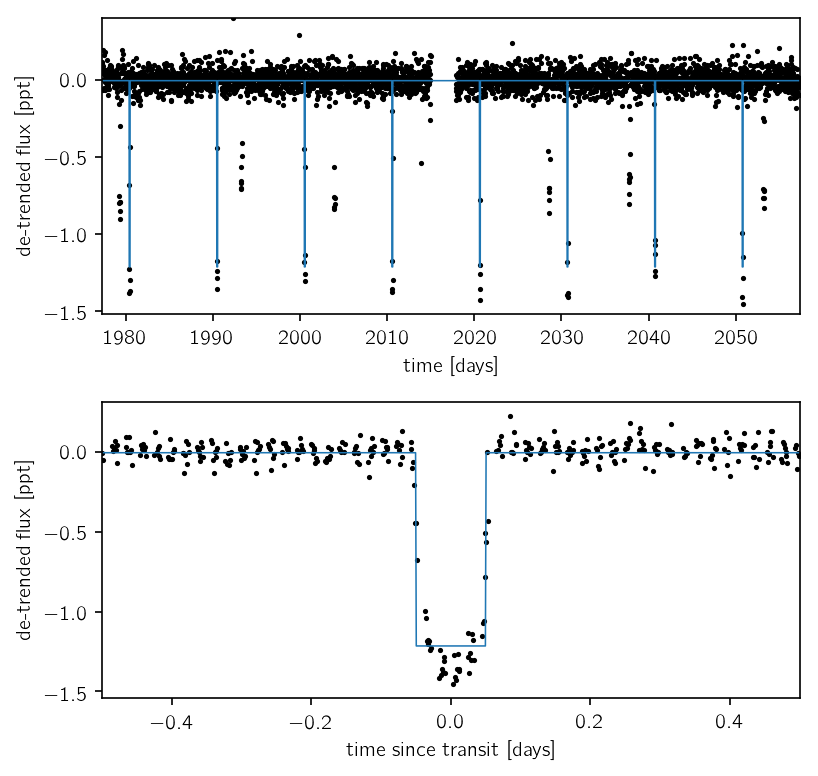

In [14]:
# Extract the parameters of the best-fit model
index = np.argmax(results.power)
period = results.period[index]
t0 = results.transit_time[index]
duration = results.duration[index]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))
fig.subplots_adjust(hspace=0.3)

# Plot the light curve and best-fit model
ax = axes[0]
ax.plot(t, y_filt, ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model.model(x, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-1.52, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

# Plot the folded data points within 0.5 days of the transit time
ax = axes[1]
x = (t - t0 + 0.5*period) % period - 0.5*period
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[m], ".k", ms=3)

# Over-plot the best fit model
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model.model(x + t0, period, duration, t0)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

That looks pretty good!

The standard way to find more planets in a light curve where the highest signal-to-noise transit has been detected is to remove the in-transit data points and then run the algorithm again.
We can do that using the `TransitPeriodogram.transit_mask` method

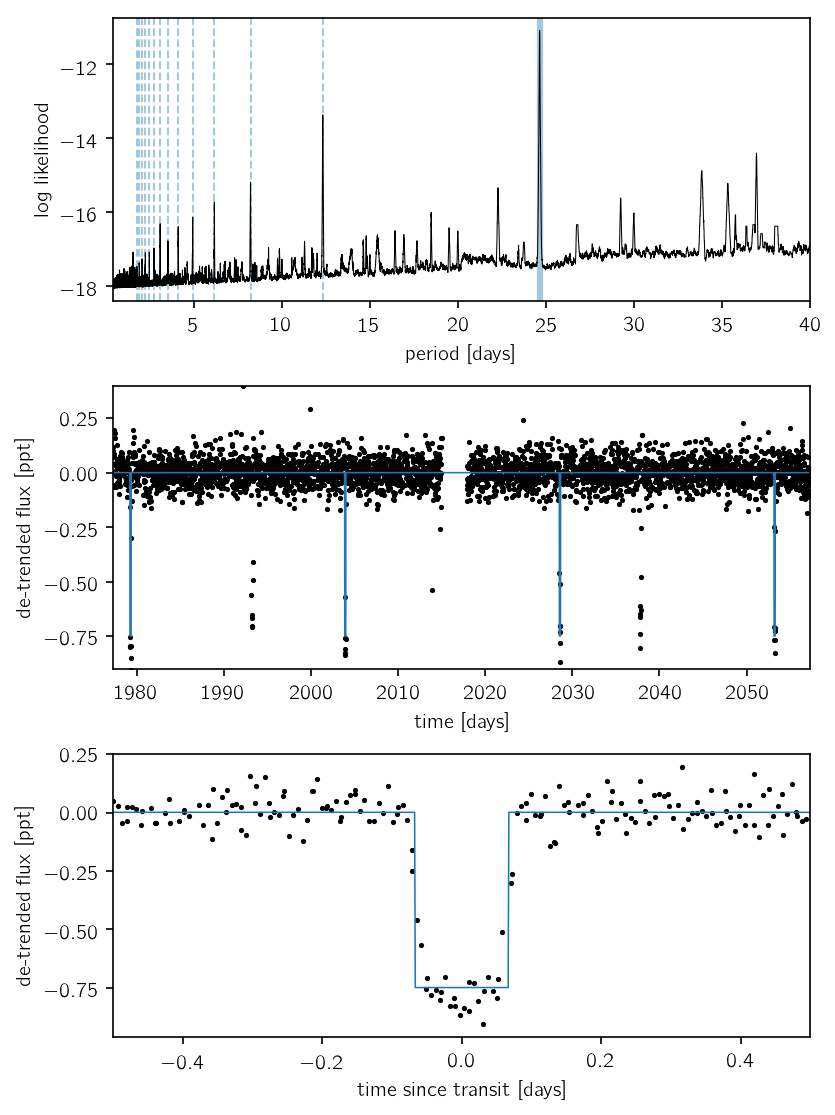

In [15]:
# Find the in-transit points using a longer duration as a buffer to avoid ingress and egress
in_transit = model.transit_mask(t, period, 2*duration, t0)

# Re-run the algorithm, and plot the results
model2 = TransitPeriodogram(t[~in_transit], y_filt[~in_transit])
results2 = model2.autopower(durations)

# Extract the parameters of the best-fit model
index = np.argmax(results2.power)
period2 = results2.period[index]
t02 = results2.transit_time[index]
duration2 = results2.duration[index]

fig, axes = plt.subplots(3, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.3)

# Highlight the harmonics of the peak period
ax = axes[0]
ax.axvline(period2.value, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period2.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period2.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results2.period, results2.power, "k", lw=0.5)

ax.set_xlim(results2.period.min().value, results2.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

# Plot the light curve and best-fit model
ax = axes[1]
ax.plot(t[~in_transit], y_filt[~in_transit], ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model2.model(x, period2, duration2, t02)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-0.9, 0.4)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]");

ax = axes[2]
x = (t[~in_transit] - t02 + 0.5*period2) % period2 - 0.5*period2
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[~in_transit][m], ".k", ms=3)
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model2.model(x + t02, period2, duration2, t02)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

As before, we can also compute some descriptive stats for this candidate.

In [16]:
model2.compute_stats(period2, duration2, t02)

{'depth': (0.75007959733930762, 0.20070696579585914),
 'depth_even': (0.74383481113355132, 0.2778603300977977),
 'depth_half': (0.50652119617169711, 0.16526124604144968),
 'depth_odd': (0.75684478239554354, 0.28916538425668015),
 'depth_phased': (-0.00088586575734961738, 0.28916705509009644),
 'harmonic_delta_log_likelihood': -6.9477683142631577,
 'per_transit_count': array([6, 6, 7, 6]),
 'per_transit_log_like': array([-5.5343336 , -5.53867986, -6.51205449, -5.51907852]),
 'rms_in_transit': 0.10224799226361808,
 'rms_out_of_transit': 0.078764852307087838,
 'transit_times': <Quantity [ 1979.27543339, 2003.92265756, 2028.56988173, 2053.2171059 ] d>}

Now let's do it one more time to find the third planet.

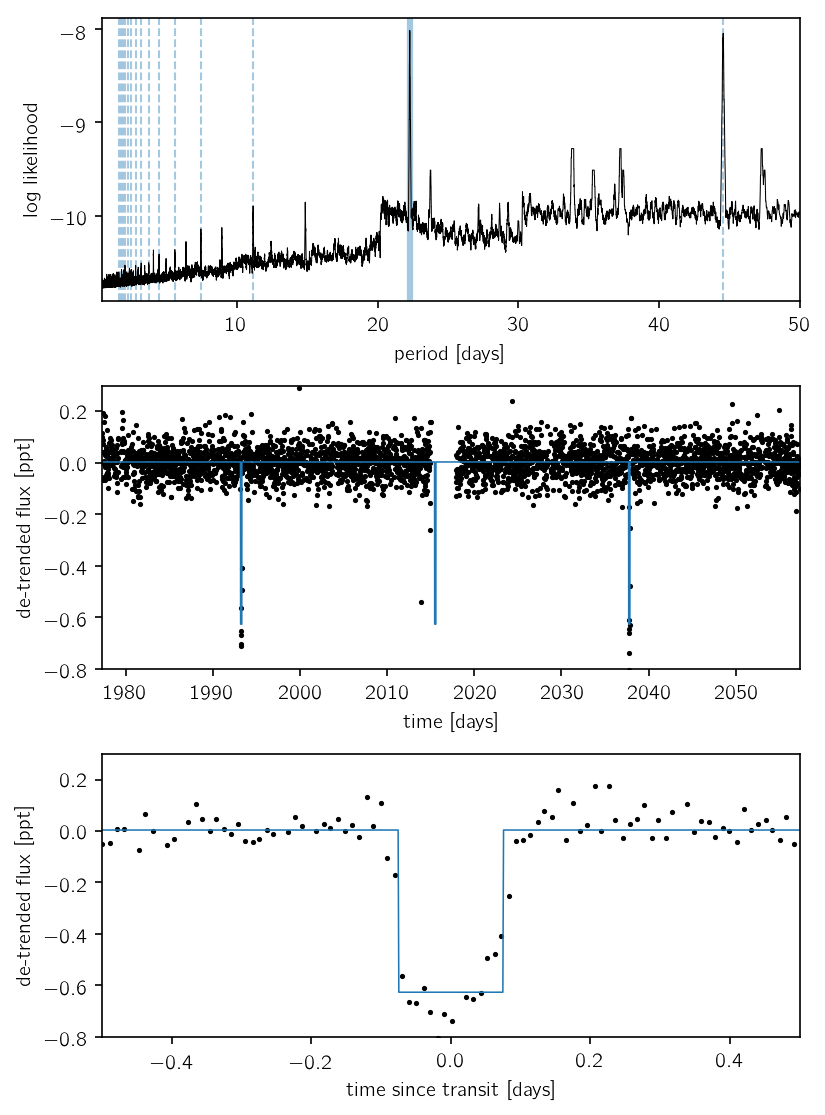

In [17]:
in_transit2 = in_transit | model2.transit_mask(t, period2, 2*duration2, t02)

# Re-run the algorithm, and plot the results
model3 = TransitPeriodogram(t[~in_transit2], y_filt[~in_transit2])
results3 = model3.autopower(durations, maximum_period=50)

# Extract the parameters of the best-fit model
index = np.argmax(results3.power)
period3 = results3.period[index]
t03 = results3.transit_time[index]
duration3 = results3.duration[index]

fig, axes = plt.subplots(3, 1, figsize=(6, 9))
fig.subplots_adjust(hspace=0.3)

# Highlight the harmonics of the peak period
ax = axes[0]
ax.axvline(period3.value, alpha=0.4, lw=3)
for n in range(2, 15):
    ax.axvline(n*period3.value, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(period3.value / n, alpha=0.4, lw=1, linestyle="dashed")

# Plot the periodogram
ax.plot(results3.period, results3.power, "k", lw=0.5)

ax.set_xlim(results3.period.min().value, results3.period.max().value)
ax.set_xlabel("period [days]")
ax.set_ylabel("log likelihood")

ax = axes[1]
ax.plot(t[~in_transit2], y_filt[~in_transit2], ".k", ms=3)
x = np.linspace(t.min(), t.max(), 3*len(t))
f = model3.model(x, period3, duration3, t03)
ax.plot(x, f, lw=0.75)
ax.set_xlim(t.min().value, t.max().value)
ax.set_ylim(-0.8, 0.3)
ax.set_xlabel("time [days]")
ax.set_ylabel("de-trended flux [ppt]")

ax = axes[2]
x = (t[~in_transit2] - t03 + 0.5*period3) % period3 - 0.5*period3
m = np.abs(x) < 0.5 * u.day
ax.plot(x[m], y_filt[~in_transit2][m], ".k", ms=3)
x = np.linspace(-0.5, 0.5, 1000) * u.day
f = model3.model(x + t03, period3, duration3, t03)
ax.plot(x, f, lw=0.75)
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.8, 0.3)
ax.set_xlabel("time since transit [days]")
ax.set_ylabel("de-trended flux [ppt]");

Interestingly, this time the detected period is actually half of the period reported in the literature.
Looking at the second plot above, it should be possible to figure out what is going on here.
In fact, the likelihood of the correct period is actually *identical* to the peak reported here because the middle transit falls in a data gap, but `np.argmax` returns the *first* index when multiple entries have the same value.
This issue can immediately be identified when we run `compute_stats`:

In [18]:
model3.compute_stats(period3, duration3, t03)

{'depth': (0.63012476407092333, 0.26779675946482406),
 'depth_even': (0.0, inf),
 'depth_half': (0.19400073606454776, 0.15171120613953734),
 'depth_odd': (0.63012476407092333, 0.26779675946482406),
 'depth_phased': (-0.0094857585847922497, 0.18336398412549232),
 'harmonic_delta_log_likelihood': -2.7397420411843996,
 'per_transit_count': array([7, 0, 7]),
 'per_transit_log_like': array([-6.47439368,  0.        , -6.46644876]),
 'rms_in_transit': 0.10399380044006601,
 'rms_out_of_transit': 0.067439343732069459,
 'transit_times': <Quantity [ 1993.22909845, 2015.50436921, 2037.77963998] d>}

In this case, the `per_transit_count` statistic shows us that there are no data points in the middle transit because it falls in a gap.